In [138]:
import datetime
import duckdb
import enum
import json
import matplotlib.pyplot as plt
import ollama
import os
import pandas as pd
import pydantic
import requests
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
import tqdm
from typing import Dict, List

# Prompt Exploration

In [113]:
LABELS_WORKLOAD = ["low", "medium", "high", "unknown"]
LABELS_REASON = ["performance", "injury", "opponent", "unknown"]


class ExpectedWorkloadEnum(enum.Enum):
    high = "high"
    medium = "medium"
    low = "low"
    unknown = "unknown"


class ReasonCategoryEnum(enum.Enum):
    performance = "performance"
    injury = "injury"
    opponent = "opponent"
    unknown = "unknown"


class ExpectedWorkloadReport(pydantic.BaseModel):
    expected_workload: ExpectedWorkloadEnum
    reason_category: ReasonCategoryEnum


def strip_code_block(raw: str) -> str:
    return raw.lstrip("```json").lstrip("```").rstrip("```")


def extract_expected_workload_change(model_config: Dict, report: Dict) -> Dict:
    is_debug = model_config.get("is_debug", False)
    template_kwargs = dict(
        player_name=report.get("player_name"),
        report_content=report.get("description"),
    )
    prompt_template = model_config.get("prompt_template")
    prompt = prompt_template.format(**template_kwargs)
    res = ollama.chat(
        model=model_config.get("model"),
        messages=[{ "role": "user", "content": prompt}],
        format=ExpectedWorkloadReport.model_json_schema(),
        think=model_config.get("think"),
        options=dict(
            temperature=model_config.get("temperature"),
            top_p=model_config.get("top_p"),
        ),
    )
    raw_message = res.message.content
    duration_secs = res.total_duration / 1000000000
    if is_debug:
        print(f"Total Duration: {duration_secs:.1f} secs")
        if model_config.get("think") is not None:
            print()
            print(res.message.thinking)
    raw_json = strip_code_block(raw_message)
    data = json.loads(raw_json)
    if is_debug:
        print()
        print(json.dumps(data))
    return data


def process_report(model_config: Dict, r: Dict) -> Dict:
    expected = extract_expected_workload_change(model_config=model_config, report=r)
    return {
        "report_id": r.get("report_id"),
        "expected_workload": expected.get("expected_workload", "unknown"),
        "reason_category": expected.get("reason_category", "unknown"),
    }


def get_report_predictions(model_config: Dict, reports: List[Dict]) -> List[Dict]:
    result_iterator = map(lambda r: process_report(model_config, r), reports)
    output = list(tqdm.tqdm(result_iterator, total=len(reports)))
    return output

In [105]:
PLAYER_NAME = "Zonovan Knight"
CONTENT = """
Arizona Cardinals running back Bam Knight had 10 carries for 12 yards and a touchdown in Sunday's 27-24 overtime loss to the Jacksonville Jaguars in Week 12. He added four catches on five targets for 20 yards through the air. Knight was able to tough out an ankle injury that had limited him in practice leading up to Sunday's performance. The 24-year-old had to find the end zone to save his Week 12 fantasy performance, and he has now scored a touchdown in back-to-back weeks to stay fantasy viable. In a high-volume passing offense, Knight has become a touchdown-dependent running back in all fantasy formats. Since Week 9, over a third of Knight's fantasy points have come from his touchdown production. Heading into Week 13 against the Tampa Bay Buccaneers, Knight's short-term fantasy appeal could run out if Trey Benson (knee) returns from Injured Reserve.
"""

In [106]:
MODEL_GEMMA = "gemma3:1b"
MODEL_GPT = "gpt-oss:20b"

PROMPT_TEST = """
# Instructions

You are an expert in NFL football and semantics.

Read the following news report about an NFL player and extract structured data that captures what the report
thinks that player's workload will be in the next game.

If multiple players are mentioned in the report, only extract the expected workload of the target player.

In fantasy sports terminology, news reports may refer to players like this:
- RB1: The top‑tier running back on a team, usually the highest projected scorer.  
- RB2: The second‑best running back, next in value after RB1.  
- RB3: The third running back, often a bench or flex candidate.  
- Flex: A slot that can hold a RB, WR, or TE; the spot you fill with the best available from those positions.  
- High‑end flex: A star‑level player (often a top RB or WR) placed in the flex slot to maximize upside.  
- Low‑end flex: A lower‑tier or backup player used in flex when you’re not targeting a high‑scoring option.

Your output should be JSON with the following fields:
- "expected_workload"
  - The expected workload in the next game (carries, targets) for the target player
  - Value can be one of the following:
    - "high" if significant workload (20+ touches), especially for the lead player in their role
    - "medium" if workload is in the middle (10-20 touches), especially when split with another key player
    - "low" if even less workload than that (<10 touches) or no workload at all
    - "unknown" if it cannot be determined
- "reason_category"
  - Categorization of the primary reason for the expected workload change
  - Value can be one of the following:
    - "performance" because of the target player or another player's strong or weak play
    - "injury" because of an injury to or return from injury by the target player or another player
    - "opponent" because of the strength or weakness of the team they are playing against next week
    - "rumor" because of hearsay about players, coaches, or strategy
    - "unknown" if the reason cannot be determined

# Examples

## Example 1

Target Player:
J.K. Dobbins

Report:
Denver Broncos running back J.K. Dobbins delivered a solid performance in Week 3 despite his team's last-second 23-20 loss to the Los Angeles Chargers. Dobbins was effective on the ground, rushing for 83 yards and a touchdown on 11 carries, including a 41-yard run that helped set up his score. He also recorded one catch for zero yards. After three games, Dobbins has been highly productive, averaging 5.4 yards per carry with over 220 rushing yards and three touchdowns. He seems to be secured as the lead back and is likely to continue seeing a significant workload as rookie R.J. Harvey struggles to find his rhythm. Dobbins can be viewed as a reliable RB2 option moving forward.

Output:
{{
  'expected_workload': 'high',
  'reason_category': 'performance'
}}

## Example 2

Target Player:
Justice Hill

Report:
Baltimore Ravens head coach John Harbaugh said on Monday that running back Justice Hill (neck) will be out three to four weeks with a disc issue in his neck, but there's still a chance that he will return this year, according to Jonas Shaffer of The Baltimore Sun. Hill injured his neck in practice early last week and landed on Injured Reserve before the Thanksgiving Day loss to the Cincinnati Bengals on Thursday night. The 28-year-old pass-catching back will miss at least three more games, but he will be eligible to return from IR in Week 17 on the road at Lambeau Field against the Green Bay Packers. Keaton Mitchell was starting to take on a bigger role behind starter Derrick Henry even before Hill was injured, so if he does return before the end of the 2025 regular season, Hill could be Baltimore's RB3 on passing downs. He only has 18 rushing attempts on the year for 93 yards and two TDs, adding 169 receiving yards and one score.

Output:
{{
  'expected_workload': 'low',
  'reason_category': 'injury'
}}

## Example 3

Target Player:
Devin Singletary

Report:
New York Giants running back Devin Singletary had 14 carries for 47 yards in Week 12's 34-27 loss in overtime to the Detroit Lions. While the 14 carries appear encouraging, the 3.36 YPC does not. Additionally, Tyrone Tracy Jr. played 71 percent of the snaps and out-touched Singletary 23 to 14. Additionally, Tracy Jr. continues to be a running back involved in the passing game and getting a majority of the carries, with Singletary being brought in as a goal-line or change-of-pace back. Given Singletary's 14 carries and the possibility of being the team's goal-line back, he is still worth a hold in fantasy, but not someone that can confidently be started unless we see a shift in snap percentage or Tracy were to go down with an injury. Week 13 presents a challenging task: going to Foxboro to take on New England's stiff run defense, which has allowed the fewest fantasy points to opposing running backs this season. Singletary will not be a recommended start in Week 13, but could be held on fantasy managers' bench if they have the spot available.

Output:
{{
  'expected_workload': 'medium',
  'reason_category': 'opponent'
}}

# Your Turn

Target Player:
{player_name}

Report:
{report_content}

Output:
"""

In [107]:
process_report(
    model_config=dict(
        model=MODEL_GEMMA,
        think=None,
        prompt_template=PROMPT_TEST,
        temperature=0.25,
        top_p=0.5,
        is_debug=True,
    ),
    r=dict(
        report_id=42,
        player_name=PLAYER_NAME,
        description=CONTENT,
    )
)

Total Duration: 1.8 secs

{"expected_workload": "medium", "reason_category": "opponent"}


{'report_id': 42, 'expected_workload': 'medium', 'reason_category': 'opponent'}

In [108]:
process_report(
    model_config=dict(
        model=MODEL_GPT,
        think="low",
        prompt_template=PROMPT_TEST,
        temperature=0.25,
        top_p=0.5,
        is_debug=True,
    ),
    r=dict(
        report_id=42,
        player_name=PLAYER_NAME,
        description=CONTENT,
    )
)

Total Duration: 4.0 secs

We need expected workload for Zonovan Knight. Report says he had 10 carries, 4 catches. Mentions ankle injury limited him. Also says short-term fantasy appeal could run out if Trey Benson returns. So workload likely low? He had limited touches. So expected workload low. Reason category: injury (his ankle) or opponent? It's about his ankle injury limiting him. So injury. Output JSON.

{"expected_workload": "low", "reason_category": "injury"}


{'report_id': 42, 'expected_workload': 'low', 'reason_category': 'injury'}

# Model Validation

In [178]:
classification_cmap = sns.color_palette("viridis", as_cmap=True)
consistency_cmap = sns.color_palette("magma", as_cmap=True)


def plot_confusion_matrices(labeled, preds, title, cmap):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    fig.suptitle(title)
    
    ax = axes[0]
    y_real = [y.get("expected_workload") for y in labeled]
    y_pred = [y.get("expected_workload") for y in preds]
    cm = confusion_matrix(y_real, y_pred, labels=LABELS_WORKLOAD)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS_WORKLOAD)
    disp.plot(ax=ax, cmap=cmap)
    ax.set_title("Workload")
    
    ax = axes[1]
    y_real = [y.get("reason_category") for y in labeled]
    y_pred = [y.get("reason_category") for y in preds]
    cm = confusion_matrix(y_real, y_pred, labels=LABELS_REASON)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS_REASON)
    disp.plot(ax=ax, cmap=cmap)
    ax.set_title("Reason")
    
    return fig

In [149]:
df_labels = pd.read_csv("../data/labeled/report_rb.csv").query("set == 'validate'")
df_labels.head(3)

,report_id,position,player_name,week,team,opponent,player_id,game_id,season,played_at,published_at,title,description,expected_workload,reason_category,set,template,is_repeat
1,rotoballer_202860,RB,Jonathan Taylor,4,IND,LAR,6813,202510432,2025,2025-09-28 03:05 PM,2025-09-27 07:30 AM,Jonathan Taylor a Top-Six Option in Week 4,Indianapolis Colts running back Jonathan Taylo...,high,performance,validate,Target Player:\nJonathan Taylor\n\nReport:\nIn...,N
2,rotoballer_203836,RB,Rico Dowdle,6,CAR,DAL,7021,202510605,2025,2025-10-12 12:00 PM,2025-10-07 09:59 AM,Rico Dowdle Dominates in Week 5; Earns More Time?,Carolina Panthers running back Rico Dowdle had...,high,injury,validate,Target Player:\nRico Dowdle\n\nReport:\nCaroli...,N
3,rotoballer_203743,RB,David Montgomery,6,DET,KC,5892,202510616,2025,2025-10-12 07:20 PM,2025-10-05 11:33 PM,"David Montgomery Gets Involved in Trickery, To...",Detroit Lions running back David Montgomery ru...,high,performance,validate,Target Player:\nDavid Montgomery\n\nReport:\nD...,N


In [150]:
validate_reports = df_labels[["report_id", "player_name", "description"]].to_dict(orient="records")
labeled_reports = df_labels[["report_id", "expected_workload", "reason_category"]].to_dict(orient="records")

## Model Selection

In [111]:
pred_gemma = get_report_predictions(
    model_config=dict(
        model=MODEL_GEMMA,
        think=None,
        prompt_template=PROMPT_TEST,
        temperature=0.25,
        top_p=0.5,
    ),
    reports=validate_reports,
)

100%|███████████████████████████████████████████| 33/33 [00:42<00:00,  1.28s/it]


In [112]:
pred_gpt = get_report_predictions(
    model_config=dict(
        model=MODEL_GPT,
        think="low",
        prompt_template=PROMPT_TEST,
        temperature=0.25,
        top_p=0.5,
    ),
    reports=validate_reports,
)

100%|███████████████████████████████████████████| 33/33 [01:06<00:00,  2.01s/it]


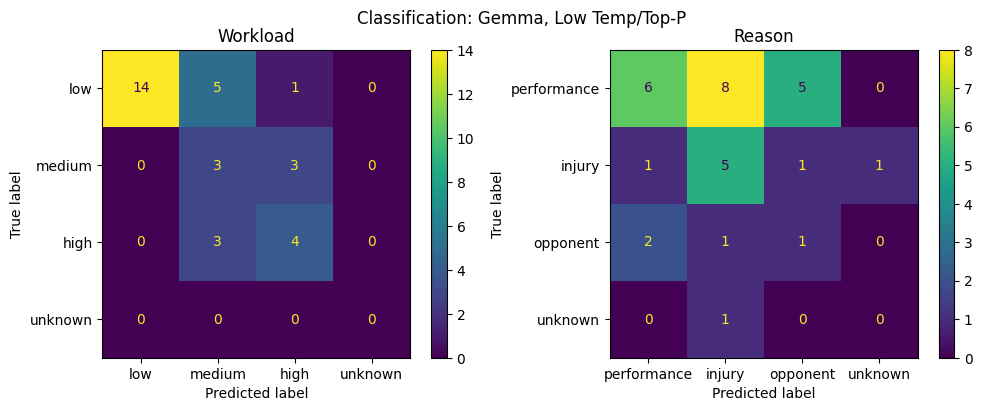

In [172]:
fig = plot_confusion_matrices(
    labeled_reports,
    pred_gemma,
    title="Classification: Gemma, Low Temp/Top-P",
    cmap=classification_cmap
)
fig.savefig("../docs/assets/results/classification_gemma.png")
plt.show()

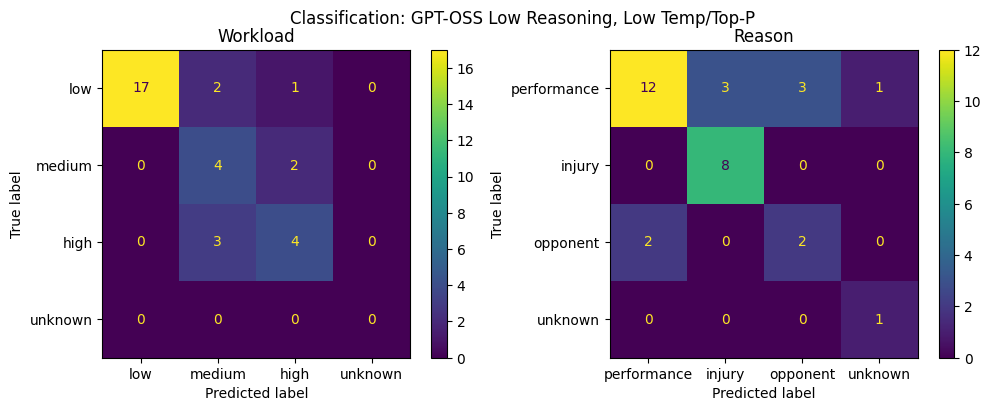

In [186]:
fig = plot_confusion_matrices(
    labeled_reports,
    pred_gpt,
    title="Classification: GPT-OSS Low Reasoning, Low Temp/Top-P",
    cmap=classification_cmap
)
fig.savefig("../docs/assets/results/classification_gptoss.png")
plt.show()

In [191]:
pred_deepseek = get_report_predictions(
    model_config=dict(
        model="deepseek-r1:1.5b",
        think=None,
        prompt_template=PROMPT_TEST,
        temperature=0.25,
        top_p=0.5,
    ),
    reports=validate_reports,
)

100%|███████████████████████████████████████████| 33/33 [03:58<00:00,  7.22s/it]


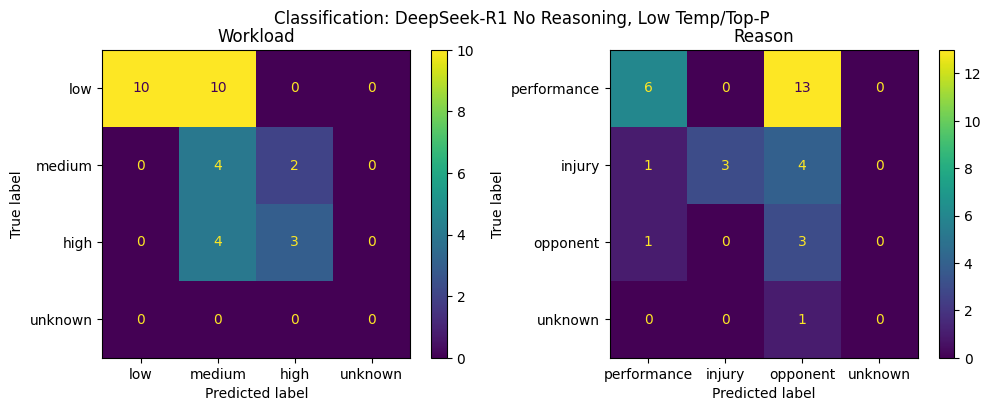

In [192]:
fig = plot_confusion_matrices(
    labeled_reports,
    pred_deepseek,
    title="Classification: DeepSeek-R1 No Reasoning, Low Temp/Top-P",
    cmap=classification_cmap
)
fig.savefig("../docs/assets/results/classification_deepseek.png")
plt.show()

## Consistency Analysis

In [139]:
pred_gpt_rerun = get_report_predictions(
    model_config=dict(
        model=MODEL_GPT,
        think="low",
        prompt_template=PROMPT_TEST,
        temperature=0.25,
        top_p=0.5,
    ),
    reports=validate_reports,
)

100%|███████████████████████████████████████████| 33/33 [01:07<00:00,  2.04s/it]


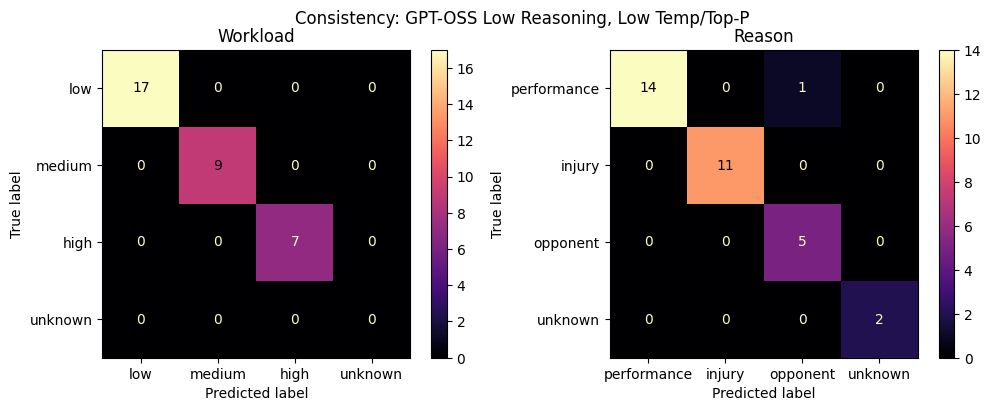

In [187]:
fig = plot_confusion_matrices(
    pred_gpt,
    pred_gpt_rerun,
    title="Consistency: GPT-OSS Low Reasoning, Low Temp/Top-P",
    cmap=consistency_cmap
)
fig.savefig("../docs/assets/results/consistency_gptoss.png")
plt.show()

In [144]:
pred_gpt_no_temp = get_report_predictions(
    model_config=dict(
        model=MODEL_GPT,
        think="low",
        prompt_template=PROMPT_TEST,
    ),
    reports=validate_reports,
)

100%|███████████████████████████████████████████| 33/33 [01:13<00:00,  2.22s/it]


In [145]:
pred_gpt_no_temp_rerun = get_report_predictions(
    model_config=dict(
        model=MODEL_GPT,
        think="low",
        prompt_template=PROMPT_TEST,
    ),
    reports=validate_reports,
)

100%|███████████████████████████████████████████| 33/33 [01:10<00:00,  2.14s/it]


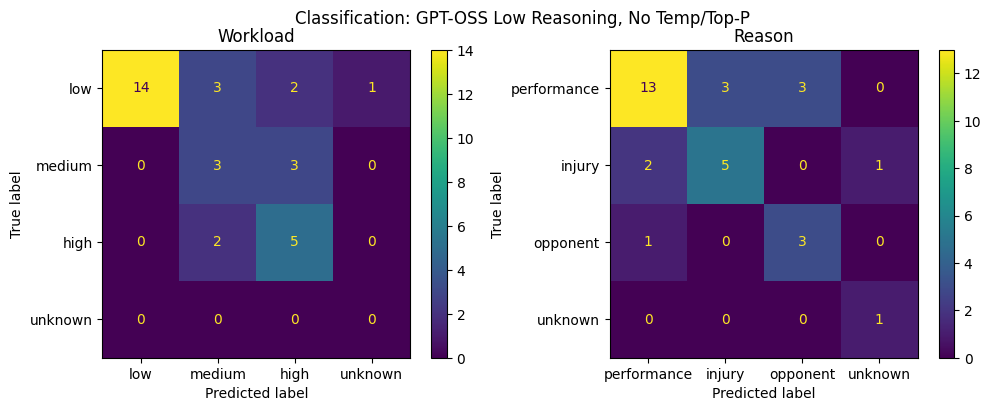

In [188]:
fig = plot_confusion_matrices(
    labeled_reports,
    pred_gpt_no_temp,
    title="Classification: GPT-OSS Low Reasoning, No Temp/Top-P",
    cmap=classification_cmap
)
fig.savefig("../docs/assets/results/classification_gptossnotemp.png")
plt.show()

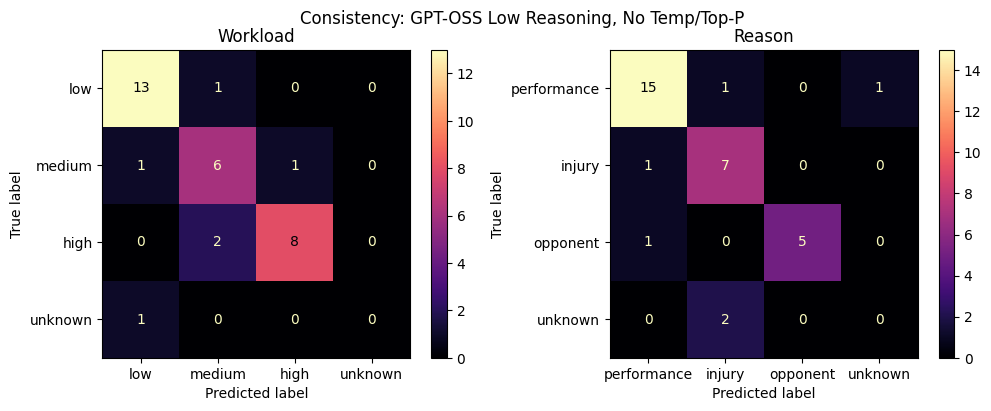

In [189]:
fig = plot_confusion_matrices(
    pred_gpt_no_temp,
    pred_gpt_no_temp_rerun,
    title="Consistency: GPT-OSS Low Reasoning, No Temp/Top-P",
    cmap=consistency_cmap
)
fig.savefig("../docs/assets/results/consistency_gptossnotemp.png")
plt.show()

## Reasoning Strength Selection

In [182]:
pred_gpt_med = get_report_predictions(
    model_config=dict(
        model=MODEL_GPT,
        think="medium",
        prompt_template=PROMPT_TEST,
        temperature=0.25,
        top_p=0.5,
    ),
    reports=validate_reports,
)

100%|███████████████████████████████████████████| 33/33 [06:02<00:00, 10.99s/it]


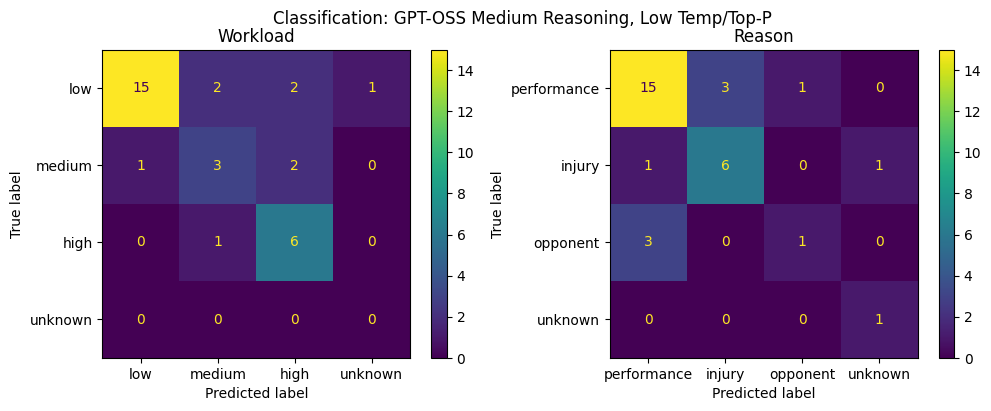

In [190]:
fig = plot_confusion_matrices(
    labeled_reports,
    pred_gpt_med,
    title="Classification: GPT-OSS Medium Reasoning, Low Temp/Top-P",
    cmap=classification_cmap
)
fig.savefig("../docs/assets/results/classification_gptossmed.png")
plt.show()